In [1]:
import yaml

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import create_model, pull_data, fit_give, estimate_population_uncertainty
from electronfactors.visuals.utilities import create_green_cm

In [33]:
from electronfactors.visuals.utilities import create_green_cm
green_cm = create_green_cm()

def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

rc('legend', fontsize=16)

In [3]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [55]:
def test_amount(amount=8, n=1000):
    store = np.array([])
    
    for j in range(n):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]        
        check = np.setdiff1d(np.arange(len(width)), reference)        
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        model = create_model(width[reference], eqPonA[reference], factor[reference])

        for i, value in enumerate(check):
            predictions[i] = model(width[value], eqPonA[value])
            give[i] = fit_give(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference], factor[reference])

        percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

        valid = give < 0.5
        store = np.append(store, percent_prediction_differences[valid])
    
    std_store = np.std(store)
    
    return std_store

In [56]:
amount_test = np.arange(8, 40)
std_store = np.zeros(len(amount_test))

for i, amount in enumerate(amount_test):
    std_store[i] = test_amount(amount=amount, n=100)  # n=30000
    

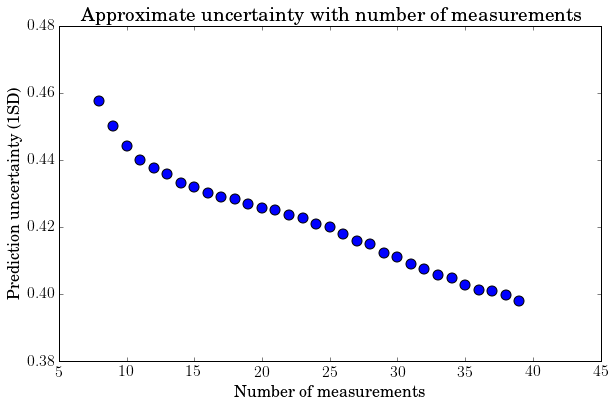

In [6]:
# plt.figure(figsize=(6 * 1.618, 6))

# plt.scatter(amount_test, np.sqrt(std_mean_diff**2 + std_individual_std**2 + avg_individual_std**2), s=100)

# # plt.title(r'Approximate uncertainty with number of measurements')
# plt.xlabel(r'Number of measurements')
# plt.ylabel(r'Prediction uncertainty (1SD)')

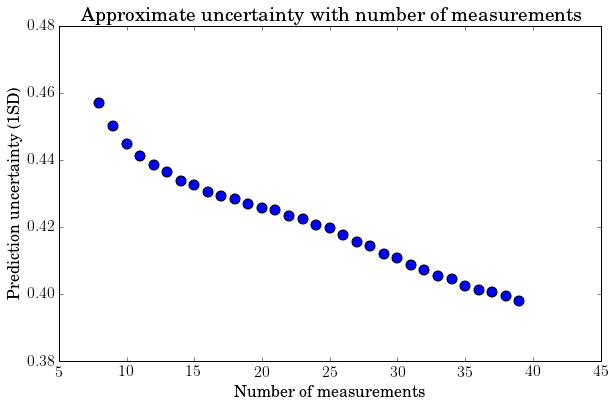

In [7]:
plt.figure(figsize=(6 * 1.618, 6))

plt.scatter(amount_test, std_store, s=100)

# plt.title(r'Approximate uncertainty with number of measurements')
plt.xlabel(r'Number of measurements')
plt.ylabel(r'Approximate prediction uncertainty (1SD)')

plt.savefig('figures/change_with_number_measurements.png', bbox_inches='tight', dpi=600)
# plt.savefig('figures/example_ellipse.pdf', bbox_inches='tight', dpi=600)
fig.savefig('figures/change_with_number_measurements.eps', bbox_inches='tight')

In [8]:
from scipy.stats import linregress


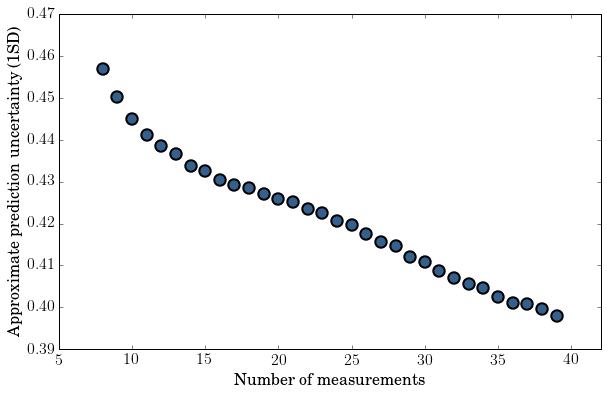

In [41]:
point_a = 11
point_b = 11



test_a = np.arange(0, np.where(amount_test==point_a)[0][0] + 1)
slope_a, intercept_a, r_value, p_value, std_err = linregress(amount_test[test_a], std_store[test_a])

# test_b = np.arange(np.where(amount_test==point_a)[0][0] + 1, np.where(amount_test==point_b)[0][0] + 1)
# slope_b, intercept_b, r_value, p_value, std_err = linregress(amount_test[test_b], std_store[test_b])

test_c = np.arange(np.where(amount_test==point_b)[0][0] + 1, len(amount_test))
slope_c, intercept_c, r_value, p_value, std_err = linregress(amount_test[test_c], std_store[test_c])


x_a = np.linspace(8, point_a)
# x_b = np.linspace(point_a + 1, point_b)
x_c = np.linspace(point_b + 1, 39)


plt.figure(figsize=(6 * 1.618, 6))

plt.scatter(amount_test, std_store, s=130, lw=2, c=colour(0.3, alpha=1))

# plt.plot(x_a, x_a*slope_a + intercept_a, lw=2)
# # plt.plot(x_b, x_b*slope_b + intercept_b, lw=2)
# plt.plot(x_c, x_c*slope_c + intercept_c, lw=2)

plt.xlabel(r'Number of measurements')
plt.ylabel(r'Approximate prediction uncertainty (1SD)')

plt.xlim([5,42])
plt.ylim([0.39, 0.47])

plt.savefig('figures/change_with_number_measurements.png', bbox_inches='tight', dpi=600)
# plt.savefig('figures/example_ellipse.pdf', bbox_inches='tight', dpi=600)
plt.savefig('figures/change_with_number_measurements.eps', bbox_inches='tight')

In [16]:
slope_a

-0.00529001826843809

In [18]:
slope_b

-0.0015045880575148838

In [47]:
def test_amount_with_outlier(amount=8, n=1000, num_outliers=2):
    store = np.array([])
    
    for j in range(n):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]
        
        shift = np.floor(np.random.uniform(0,2, size=num_outliers)) * 0.04 - 0.02
        shifted_factor = factor[reference]
        shifted_factor[0:num_outliers] = shifted_factor[0:num_outliers] + shift
        
        check = np.setdiff1d(np.arange(len(width)), reference)
        
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        model = create_model(width[reference], eqPonA[reference], shifted_factor)

        for i, value in enumerate(check):
            predictions[i] = model(width[value], eqPonA[value])
            give[i] = fit_give(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference], factor[reference])

        percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

        valid = give < 0.5
        store = np.append(store, percent_prediction_differences[valid])            
    
    std_store = np.std(store)
    
    return std_store

In [82]:
amount_test = np.arange(8, 40)
std_store_no_outlier = np.zeros(len(amount_test))
std_store_one_outlier = np.zeros(len(amount_test))
std_store_two_outliers = np.zeros(len(amount_test))
std_store_four_outliers = np.zeros(len(amount_test))
std_store_six_outliers = np.zeros(len(amount_test))

In [108]:
for i, amount in enumerate(amount_test):
    std_store_no_outlier[i] = test_amount(amount=amount, n=30000)  # n=30000

In [110]:
for i, amount in enumerate(amount_test):
    std_store_one_outlier[i] = test_amount_with_outlier(amount=amount, n=30000, num_outliers=1)

In [102]:
for i, amount in enumerate(amount_test):
    std_store_two_outliers[i] = test_amount_with_outlier(amount=amount, n=30000, num_outliers=2)    

In [89]:
# for i, amount in enumerate(amount_test):
#     std_store_four_outliers[i] = test_amount_with_outlier(amount=amount, n=1000, num_outliers=4)    

In [79]:
# for i, amount in enumerate(amount_test):
#     std_store_six_outliers[i] = test_amount_with_outlier(amount=amount, n=1000, num_outliers=6)   
    
#     std_store_six_outliers = np.append(
#         std_store_six_outliers, test_amount_with_outlier(amount=amount, n=100, num_outliers=6))

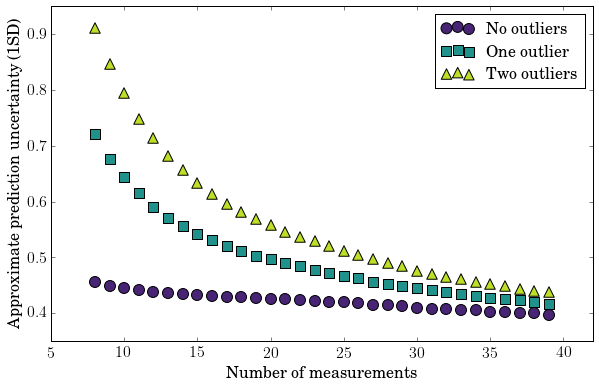

In [111]:
plt.figure(figsize=(6 * 1.618, 6))

plt.scatter(
    amount_test, std_store_no_outlier, s=120, lw=1, c=colour(0.1, alpha=1),
    label=r'No outliers'
)

plt.scatter(
    amount_test, std_store_one_outlier, marker='s', s=100, lw=1, c=colour(0.5, alpha=1),
    label=r'One outlier'
)

plt.scatter(
    amount_test, std_store_two_outliers, marker='^', s=110, lw=1, c=colour(0.9, alpha=1),
    label=r'Two outliers'
)

# plt.scatter(
#     amount_test, std_store_four_outliers, marker='p', s=140, lw=2, c=colour(0.99, alpha=1),
#     label=r'Four outliers'
# )



plt.xlabel(r'Number of measurements')
plt.ylabel(r'Approximate prediction uncertainty (1SD)')

plt.xlim([5,42])
plt.ylim([0.35,0.95])

plt.legend()

plt.savefig('figures/change_with_number_measurements.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/change_with_number_measurements.eps', bbox_inches='tight')